<h1 style="font-size:2.5em; color:#f5a442;">Machine Learning [4483] Project: A second
hand car price prediction
system with additional trends and
insights</h1>

<h2 style="font-size:1.5em; color:#808080;">Kai Broux (r0745431) and Luigi Guerriero (r0760424)</h2>
<h2 style="font-size:1.0em; color:#808080;">Master's students IIW UHasselt-KULeuven Campus Diepenbeek</h2>

# 1. Introduction

The goal of our project is to make a price prediction system for used cars and to extract interesting information and insights. The price prediction model and insights can be extracted from a dataset of different used cars. The model and insights could be then later used as a tool for a second-hand car retailer to give insights to potential customers shopping for a second-hand car. Moreover, this price prediction model and insights tool may also come in handy for a customer looking to sell his/her car.

This [`dataset`](https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes) contains data from 100 000 used cars from the UK which are divided into separate brands. Each brand is divided into a separate file and contains information about the model, year, price, transmission, mileage, fuel type, road tax, mpg and engine size.

Before we begin with the project, we need to import all libraries required for this project. Throughout the course, we will be using [`numpy`](http://www.numpy.org/) for all arrays and matrix operations, and [`matplotlib`](https://matplotlib.org/) for plotting. In this assignment, we will also use [`scipy`](https://docs.scipy.org/doc/scipy/reference/), which contains scientific and numerical computation functions and tools. 

In [147]:
# used for manipulating directory paths
import os

# Scientific and vector computation for python
import numpy as np

# used for importing .csv data
import pandas as pd

# Plotting library
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D  # needed to plot 3-D surfaces

# Optimization module in scipy
from scipy import optimize

# For determining R2
from sklearn.metrics import r2_score

# Tools for extracting how much features and which features we need
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVR

import scipy

import seaborn as sbn

# tells matplotlib to embed plots within the notebook
%matplotlib inline

# 2. Project itself

###  2.1 Loading in the data

As mentioned in the introduction a separate file of a car brand is stored in a `.csv` file and consist of the following columns:

    Model: Model type.
    Year: Registration Year.
    Price: Price in euros.
    Transmission: Type of Gearbos.
    Mileage: Distance Used.
    FuelType: Engine Fuel.
    Tax: Road Tax.
    mpg: Miles per Gallon.
    EngineSize: Size in litres.
    Brand: Name of the car brand.

Because the dataset also includes an abundance of information of a specefic car model, we will leave them outside of the dataset and only consider a brand with different models. Therefore we will leave out the `cclass.csv` and `focus.csv` files.

To load in the dataset, we first have to load in the separate `.csv` files. 

In [61]:
audi = pd.read_csv("dataset/audi.csv")
bmw = pd.read_csv("dataset/bmw.csv")
ford = pd.read_csv("dataset/ford.csv")
hyundai = pd.read_csv("dataset/hyundi.csv")
mercedes = pd.read_csv("dataset/merc.csv")
skoda = pd.read_csv("dataset/skoda.csv")
toyota = pd.read_csv("dataset/toyota.csv")
vauxhall = pd.read_csv("dataset/vauxhall.csv")
volkswagen = pd.read_csv("dataset/vw.csv")

We are having different datasets for different brands. So if we want to combine them we need to add an extra column to each `.csv` file describing the name of the brand :

In [62]:
audi['brand'] = 'audi'
bmw['brand'] = 'bmw'
ford['brand'] = 'ford'
hyundai['brand'] = 'hyundai'
mercedes['brand'] = 'mercedes'
skoda['brand'] = 'skoda'
toyota['brand'] = 'toyota'
vauxhall['brand'] = 'vauxhall'
volkswagen['brand'] = 'volkswagen'

df = pd.concat([audi,bmw,
               ford,hyundai,mercedes,skoda,toyota,
               vauxhall,volkswagen])
# drop the tax column
df.drop('tax(£)',axis=1,inplace=True)
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,brand
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,audi
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,audi
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,audi
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,audi
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,audi
...,...,...,...,...,...,...,...,...,...,...
15152,Eos,2012,5990,Manual,74000,Diesel,125.0,58.9,2.0,volkswagen
15153,Fox,2008,1799,Manual,88102,Petrol,145.0,46.3,1.2,volkswagen
15154,Fox,2009,1590,Manual,70000,Petrol,200.0,42.0,1.4,volkswagen
15155,Fox,2006,1250,Manual,82704,Petrol,150.0,46.3,1.2,volkswagen


### 2.2 Lineair regression with one variable 

To start of simply, we are going to apply linear regression with one variable to determine the price of a Mercedes C-class, more specefic the W205 model. We can use the `cclass.csv` and only look to at the the C-class from years 2014-2021.

We have to first load the dataset:

In [63]:
cclass = pd.read_csv("dataset/cclass.csv")
display(cclass)

,model,year,price,transmission,mileage,fuelType,engineSize
0,C Class,2020,30495,Automatic,1200,Diesel,2.0
1,C Class,2020,29989,Automatic,1000,Petrol,1.5
2,C Class,2020,37899,Automatic,500,Diesel,2.0
3,C Class,2019,30399,Automatic,5000,Diesel,2.0
4,C Class,2019,29899,Automatic,4500,Diesel,2.0
...,...,...,...,...,...,...,...
3894,C Class,2017,14700,Manual,31357,Diesel,1.6
3895,C Class,2018,18500,Automatic,28248,Diesel,2.1
3896,C Class,2014,11900,Manual,48055,Diesel,2.1
3897,C Class,2014,11300,Automatic,49865,Diesel,2.1


First take a look at our price density to figure out if we have to trim the data:

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

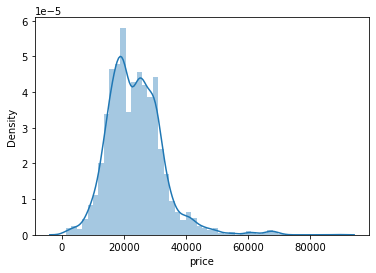

In [64]:
sbn.distplot(cclass["price"])

There are a lot of outliers above the 50000 price that do not respresent the majority of the data. So we filter out the c-classes ranging from 0-50000:

Since we want to examine the C-class W205 model we have to filter out the C-classes that are not in the 2014-2021 year-range: 

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

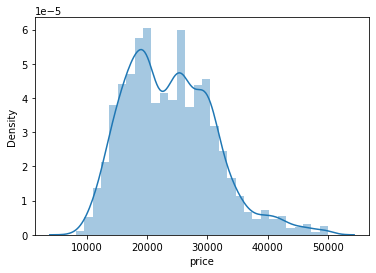

In [69]:
cclass = cclass.loc[(cclass['price'] >= 0) & (cclass['price'] <= 50000)]
sbn.distplot(cclass["price"])

In [116]:
cclass = cclass[(cclass['year'] > 2016) & (cclass['year'] < 2022)]
display(cclass)
print(len(cclass))

,model,year,price,transmission,mileage,fuelType,engineSize
0,C Class,2020,30495,Automatic,1200,Diesel,2.0
1,C Class,2020,29989,Automatic,1000,Petrol,1.5
2,C Class,2020,37899,Automatic,500,Diesel,2.0
3,C Class,2019,30399,Automatic,5000,Diesel,2.0
4,C Class,2019,29899,Automatic,4500,Diesel,2.0
...,...,...,...,...,...,...,...
3889,C Class,2017,14200,Automatic,53528,Diesel,2.1
3891,C Class,2018,23600,Automatic,18834,Petrol,2.0
3892,C Class,2018,19900,Manual,31540,Petrol,2.0
3894,C Class,2017,14700,Manual,31357,Diesel,1.6


2697


For the lineair regression with one variable, we will choose the mileage as variable (for the x-axis). The price will be selected for the y-axis. We will then visualise the data. Following function can help us to quickly plot graphs:

In [117]:
def plotData(x, y):
    fig = pyplot.figure()  # open a new figure    
    pyplot.plot(x, y, 'ro', ms=10, mec='k')
    pyplot.ylabel('Price of a W205 C-Class in £')
    pyplot.xlabel('Mileage in miles')   

[ 1200  1000   500 ... 31540 31357 28248]


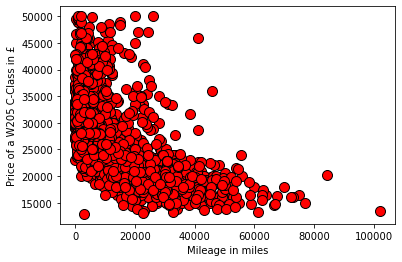

In [118]:
#X and y values of the entire dataset (for visualisation)
X_all = cclass['mileage'].to_numpy()
y_all = cclass['price'].to_numpy()
m_all = y.size #dataset size
print(X_all)

#Visualise data
plotData(X_all,y_all)

#### Splitting Data into CV, training and test set

In [119]:
cclass_shuffled = cclass.sample(frac=1)
cclass_shuffled.head()

,model,year,price,transmission,mileage,fuelType,engineSize
2777,C Class,2017,19199,Semi-Auto,25639,Diesel,2.1
7,C Class,2019,37990,Automatic,1412,Petrol,3.0
2589,C Class,2019,23499,Manual,3162,Petrol,1.6
717,C Class,2017,19980,Semi-Auto,38515,Diesel,2.1
1141,C Class,2018,20690,Semi-Auto,15900,Petrol,2.0


In [120]:
zero_60percent= int(len(cclass_shuffled)*0.6)
sixty_80percent = int(len(cclass_shuffled)*0.8)
hundred_percent = int(len(cclass_shuffled))
#print(zero_60percent)
#print(sixty_80percent)
#print(hundred_percent)
cclass_train = cclass_shuffled.iloc[0:zero_60percent]  #0-60%
cclass_CV = cclass_shuffled.iloc[zero_60percent:sixty_80percent] #20%: 60-80
cclass_test = cclass_shuffled.iloc[sixty_80percent:hundred_percent] #20%: 80-100
print(len(cclass_train),len(cclass_CV),len(cclass_test))

1618 539 540


In [121]:
#Load into X an Y
X = cclass_train['mileage'].to_numpy()
y = cclass_train['price'].to_numpy()
m = y.size #dataset size

X_CV = cclass_CV['mileage'].to_numpy()
y_CV = cclass_CV['price'].to_numpy()
m_CV = y_CV.size

X_test = cclass_test['mileage'].to_numpy()
y_test = cclass_test['price'].to_numpy()
m_test = y_test.size

#### Gradient descent  

In this part, you will fit the linear regression parameters $\theta$ to our dataset using gradient descent.

The objective of linear regression is to minimize the cost function

$$ J(\theta) = \frac{1}{2m} \sum_{i=1}^m \left( h_{\theta}(x^{(i)}) - y^{(i)}\right)^2$$

where the hypothesis $h_\theta(x)$ is given by the linear model
$$ h_\theta(x) = \theta^Tx = \theta_0 + \theta_1 x_1$$

Recall that the parameters of your model are the $\theta_j$ values. These are
the values you will adjust to minimize cost $J(\theta)$. One way to do this is to
use the batch gradient descent algorithm. In batch gradient descent, each
iteration performs the update

$$ \theta_j = \theta_j - \alpha \frac{1}{m} \sum_{i=1}^m \left( h_\theta(x^{(i)}) - y^{(i)}\right)x_j^{(i)} \qquad \text{simultaneously update } \theta_j \text{ for all } j$$

With each step of gradient descent, your parameters $\theta_j$ come closer to the optimal values that will achieve the lowest cost J($\theta$).

We first want to normalize our features to make sure our gradient descent works out without any overflow problems. Besides we add a column of ones to X:

In [122]:
mu = np.mean(X, axis = 0)
sigma = np.std(X, axis = 0)
X_norm = (X - mu) / sigma
print(X_norm)

[ 1.09816739 -0.96218304 -0.81335681 ... -0.73579708 -0.91132699
 -0.20146836]


In [123]:
# Add a column of ones to X. The numpy function stack joins arrays along a given axis. 
# The first axis (axis=0) refers to rows (training examples) 
# and second axis (axis=1) refers to columns (features).


X_not_norm = X  #save original X if we need it later
X_not_norm_stacked = np.stack([np.ones(m), X_not_norm], axis=1)  #column of ones to X
X  = np.stack([np.ones(m), X_norm], axis=1)                      #column of ones to the normalized X
print("A column of ones to X-normalized:\n", X)
print("\nA column of ones to not normalized X:\n",X_not_norm_stacked)


A column of ones to X-normalized:
 [[ 1.          1.09816739]
 [ 1.         -0.96218304]
 [ 1.         -0.81335681]
 ...
 [ 1.         -0.73579708]
 [ 1.         -0.91132699]
 [ 1.         -0.20146836]]

A column of ones to not normalized X:
 [[1.0000e+00 2.5639e+04]
 [1.0000e+00 1.4120e+03]
 [1.0000e+00 3.1620e+03]
 ...
 [1.0000e+00 4.0740e+03]
 [1.0000e+00 2.0100e+03]
 [1.0000e+00 1.0357e+04]]


For the cost function we can define a function that determines the cost:

In [124]:
def computeCost(X, y, theta):
     
    # initialize some useful values
    m = y.size  # number of training examples
    
    # You need to return the following variables correctly
    J = 0
    
    h= np.dot(X,theta)
    inner = (h-y)**2
    J = (1/(2*m)) * (np.sum(inner))

    return J

For Gradient descent we can define following function:

In [125]:
def gradientDescent(X, y, theta, alpha, num_iters):
    # Initialize some useful values
    m = y.shape[0]  # number of training examples
    
    # make a copy of theta, to avoid changing the original array, since numpy arrays
    # are passed by reference to functions
    theta = theta.copy()
    
    J_history = [] # Use a python list to save cost in every iteration
    
    for i in range(num_iters):
        # ==================== YOUR CODE HERE =================================
        theta = theta - (alpha / m) * (np.dot(X, theta) - y).dot(X)

        # =====================================================================
        
        # save the cost J in every iteration
        J_history.append(computeCost(X, y, theta))
    
    return theta, J_history



We initialize the 𝜃 parameters to 0 and the learning rate 𝛼 to 0.01 and use the final parameters to plot the lineair fit:

In [126]:
# initialize fitting parameters
theta = np.zeros(2)

# some gradient descent settings
iterations = 100000
alpha = 1

theta, J_history = gradientDescent(X ,y, theta, alpha, iterations)
print('Theta found by gradient descent: {:.4f}, {:.4f}'.format(*theta))

Theta found by gradient descent: 26466.1044, -3831.9102


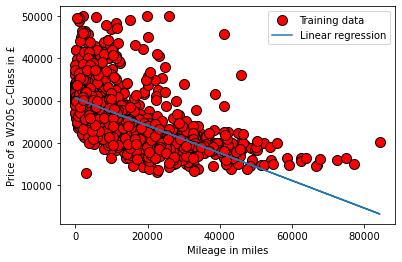

In [127]:
# plot the linear fit
plotData(X_not_norm_stacked[:, 1], y)
pyplot.plot(X_not_norm_stacked[:, 1], np.dot(X, theta), '-')
pyplot.legend(['Training data', 'Linear regression']);

## Regularised linear regression

In [128]:
def linearRegCostFunction(X, y, theta, lambda_=0.0):
    
    # Initialize some useful values
    m = y.size # number of training examples
    # You need to return the following variables correctly 
    J = 0
    grad = np.zeros(theta.shape)

    # ====================== YOUR CODE HERE ======================
    
    h= np.dot(X,theta)   
    J = (1/(2*m)) * (np.sum((h-y)**2)) + (lambda_/(2*m))*(np.sum(theta[1:]**2))   
    grad = (1 / m) * (h - y).dot(X)
    grad[1:] = grad[1:] + (lambda_ / m) * theta[1:]

    # ============================================================
    return J, grad

def trainLinearReg(linearRegCostFunction, X, y, lambda_=0.0, maxiter=200):
    """
    Trains linear regression using scipy's optimize.minimize.

    Parameters
    ----------
    X : array_like
        The dataset with shape (m x n+1). The bias term is assumed to be concatenated.

    y : array_like
        Function values at each datapoint. A vector of shape (m,).

    lambda_ : float, optional
        The regularization parameter.

    maxiter : int, optional
        Maximum number of iteration for the optimization algorithm.

    Returns
    -------
    theta : array_like
        The parameters for linear regression. This is a vector of shape (n+1,).
    """
    # Initialize Theta
    initial_theta = np.zeros(X.shape[1])

    # Create "short hand" for the cost function to be minimized
    costFunction = lambda t: linearRegCostFunction(X, y, t, lambda_)

    # Now, costFunction is a function that takes in only one argument
    options = {'maxiter': maxiter}

    # Minimize using scipy
    res = optimize.minimize(costFunction, initial_theta, jac=True, method='TNC', options=options)
    return res.x

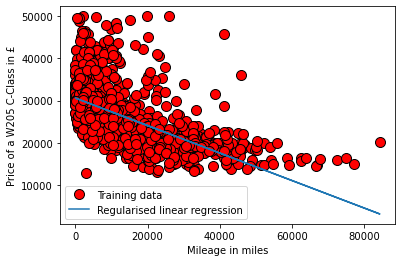

In [129]:
theta_regularized = trainLinearReg(linearRegCostFunction, X, y, lambda_=0)
# plot the linear fit
plotData(X_not_norm_stacked[:, 1], y)
pyplot.plot(X_not_norm_stacked[:, 1], np.dot(X, theta_regularized), '-')
pyplot.legend(['Training data', 'Regularised linear regression']);

In [156]:
y_pred = np.dot(X, theta_regularized)
#print(y_pred)
#print(y)
print("R² score of linear regression model: ",r2_score(y, y_pred))

R² score of linear regression model:  0.3480344054822794


### Learning curve

In [130]:
def learningCurve(X, y, Xval, yval, lambda_=0):
    # Number of training examples
    m = y.size

    # You need to return these values correctly
    error_train = np.zeros(m)
    error_val   = np.zeros(m)

    # ====================== YOUR CODE HERE ======================
    for i in range(1, m+1):
        theta_t = trainLinearReg(linearRegCostFunction, X[:i], y[:i], lambda_ = lambda_)
        error_train[i - 1], _ = linearRegCostFunction(X[:i], y[:i], theta_t, lambda_ = 0)
        error_val[i - 1], _ = linearRegCostFunction(Xval, yval, theta_t, lambda_ = 0)

        
    # =============================================================
    return error_train, error_val

We still need to add ones for the X_CV set

In [131]:
#mu_CV = np.mean(X_CV, axis = 0)
#sigma_CV = np.std(X_CV, axis = 0)
#X_CV_norm = (X_CV - mu_CV) / sigma_CV

X_CV_with_ones = np.stack([np.ones(m_CV), X_CV], axis=1)
print(X_CV_with_ones)
print(X_not_norm_stacked)

[[1.0000e+00 1.1381e+04]
 [1.0000e+00 9.6120e+03]
 [1.0000e+00 7.6210e+03]
 ...
 [1.0000e+00 2.6075e+04]
 [1.0000e+00 2.1950e+03]
 [1.0000e+00 2.4698e+04]]
[[1.0000e+00 2.5639e+04]
 [1.0000e+00 1.4120e+03]
 [1.0000e+00 3.1620e+03]
 ...
 [1.0000e+00 4.0740e+03]
 [1.0000e+00 2.0100e+03]
 [1.0000e+00 1.0357e+04]]


Plot learning curve for linear regression

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	234904114.538330
  	2		298457616.934796	198508673.362594
  	3		261291550.508438	204401168.080465
  	4		232936177.786786	239994838.589263
  	5		196053537.628414	235953423.921802
  	6		170915185.134037	233979900.887152
  	7		166558463.568098	232863748.051555
  	8		210129807.028128	233030435.749022
  	9		186479178.262598	232453526.384625
  	10		188478409.267712	233304061.739565
  	11		205011576.268914	233796890.057929
  	12		188403138.905434	233365208.099818
  	13		211223544.579483	233732536.488881
  	14		196031120.703653	233615285.980042
  	15		183526176.637292	234020593.393638
  	16		176904626.286806	234983742.009146
  	17		178923925.949362	236038904.943393
  	18		174730015.891962	237419069.503044
  	19		153923553.026277	193238642.811559
  	20		188306477.096697	234218099.328696
  	21		172803037.129095	192362135.992891
  	22		216174022.971060	235610865.740405
  	23		179122441.209666	194899575.420306
  	24		174493225.59

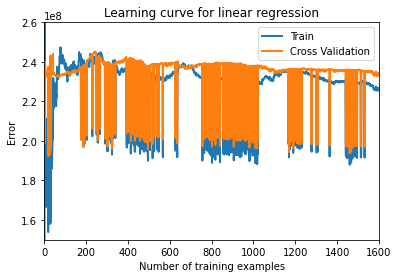

In [141]:
error_train, error_val = learningCurve(X_not_norm_stacked, y, X_CV_with_ones, y_CV, lambda_=0)
#error_train, error_val = learningCurve(X, y, X_CV_with_ones, y_CV, lambda_=0)

pyplot.plot(np.arange(1, m+1), error_train, np.arange(1, m+1), error_val, lw=2)
pyplot.title('Learning curve for linear regression')
pyplot.legend(['Train', 'Cross Validation'])
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, 1600, 150000000, 260000000])

print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train[i], error_val[i]))

## Polynomial regression

The problem with our linear model was that it was too simple for the data and resulted in underfitting (high bias).

In [37]:
def polyFeatures(X, p):
    """
    Maps X (1D vector) into the p-th power.
    
    Parameters
    ----------
    X : array_like
        A data vector of size m, where m is the number of examples.
    
    p : int
        The polynomial power to map the features. 
    
    Returns 
    -------
    X_poly : array_like
        A matrix of shape (m x p) where p is the polynomial 
        power and m is the number of examples. That is:
    
        X_poly[i, :] = [X[i], X[i]**2, X[i]**3 ...  X[i]**p]
    
    Instructions
    ------------
    Given a vector X, return a matrix X_poly where the p-th column of
    X contains the values of X to the p-th power.
    """
    # You need to return the following variables correctly.
    X_poly = np.zeros((X.shape[0], p))

    # ====================== YOUR CODE HERE ======================

    for i in range(p):
        X_poly[:, i] = X[:, 0] ** (i + 1)

    # ============================================================
    return X_poly

def plotFit(polyFeatures, min_x, max_x, mu, sigma, theta, p):
    """
    Plots a learned polynomial regression fit over an existing figure.
    Also works with linear regression.
    Plots the learned polynomial fit with power p and feature normalization (mu, sigma).

    Parameters
    ----------
    polyFeatures : func
        A function which generators polynomial features from a single feature.

    min_x : float
        The minimum value for the feature.

    max_x : float
        The maximum value for the feature.

    mu : float
        The mean feature value over the training dataset.

    sigma : float
        The feature standard deviation of the training dataset.

    theta : array_like
        The parameters for the trained polynomial linear regression.

    p : int
        The polynomial order.
    """
    # We plot a range slightly bigger than the min and max values to get
    # an idea of how the fit will vary outside the range of the data points
    x = np.arange(min_x - 15, max_x + 25, 0.05).reshape(-1, 1)

    # Map the X values
    X_poly = polyFeatures(x, p)
    X_poly -= mu
    X_poly /= sigma

    # Add ones
    X_poly = np.concatenate([np.ones((x.shape[0], 1)), X_poly], axis=1)

    # Plot
    pyplot.plot(x, np.dot(X_poly, theta), '--', lw=2)
    
    
def hypothesis(X, theta):
    y1 = theta*X
    return np.sum(y1, axis=1)

[[2.56390000e+04 6.57358321e+08 1.68540100e+13]
 [1.41200000e+03 1.99374400e+06 2.81516653e+09]
 [3.16200000e+03 9.99824400e+06 3.16144475e+10]
 ...
 [4.07400000e+03 1.65974760e+07 6.76181172e+10]
 [2.01000000e+03 4.04010000e+06 8.12060100e+09]
 [1.03570000e+04 1.07267449e+08 1.11096897e+12]]
[[ 1.09816739  0.60265266  0.19108488]
 [-0.96218304 -0.50323433 -0.29119694]
 [-0.81335681 -0.48972723 -0.29037271]
 ...
 [-0.73579708 -0.47859144 -0.28934228]
 [-0.91132699 -0.49978123 -0.2910451 ]
 [-0.20146836 -0.32559149 -0.25948154]]
[[ 1.          1.09816739  0.60265266  0.19108488]
 [ 1.         -0.96218304 -0.50323433 -0.29119694]
 [ 1.         -0.81335681 -0.48972723 -0.29037271]
 ...
 [ 1.         -0.73579708 -0.47859144 -0.28934228]
 [ 1.         -0.91132699 -0.49978123 -0.2910451 ]
 [ 1.         -0.20146836 -0.32559149 -0.25948154]]
[26466.10444994 -9238.02132475  8678.18901658 -3307.98814553]


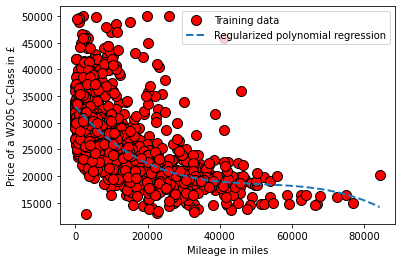

In [139]:
p = 3

X_not_norm__for_poly = np.array(X_not_norm).reshape(np.array(X_not_norm).size,1)
# Map X onto Polynomial Features 
X_not_norm_poly = polyFeatures(X_not_norm__for_poly, p)
print(X_not_norm_poly)

# normalize features
mu = np.mean(X_not_norm_poly, axis = 0)
sigma = np.std(X_not_norm_poly, axis = 0)
X_poly_norm = (X_not_norm_poly - mu) / sigma
print(X_poly_norm)
X_poly_norm_with_ones = np.concatenate([np.ones((m, 1)), X_poly_norm], axis=1)
print(X_poly_norm_with_ones)

#do the same for X_test
X_test = np.array(X_test).reshape(np.array(X_test).size,1)
X_poly_test = polyFeatures(X_test, p)
mu_poly_test = np.mean(X_poly_test, axis = 0)
sigma_poly_test = np.std(X_poly_test, axis = 0)
X_poly_test_norm = (X_poly_test - mu_poly_test) / sigma_poly_test
X_poly_test_norm_ones = np.concatenate([np.ones((m_test, 1)), X_poly_test_norm], axis=1) #concatenate ones

#do the same for X_CV
X_CV = np.array(X_CV).reshape(np.array(X_CV).size,1)
X_poly_CV = polyFeatures(X_CV, p)
mu_poly_CV = np.mean(X_poly_CV, axis = 0)
sigma_poly_CV = np.std(X_poly_CV, axis = 0)
X_poly_CV_norm = (X_poly_CV - mu_poly_CV) / sigma_poly_CV
X_poly_CV_norm_ones = np.concatenate([np.ones((m_CV, 1)), X_poly_CV_norm], axis=1) #concatenate ones


lambda_ = 0
theta_poly = trainLinearReg(linearRegCostFunction, X_poly_norm_with_ones, y,
                             lambda_=lambda_, maxiter=100000)
#theta_poly = theta_poly.reshape(1,-1)
#print(theta_poly.shape)
print(theta_poly)
h = hypothesis(X_poly_norm_with_ones[:,1].reshape(-1,1),theta_poly)
#print(h.tolist())

plotData(X_not_norm_stacked[:, 1], y)
#pyplot.plot(X_not_norm_stacked[:, 1], np.dot(X_poly_norm_with_ones, theta_poly), '-')
plotFit(polyFeatures, np.min(X_not_norm__for_poly), np.max(X_not_norm__for_poly), mu, sigma, theta_poly, p)
pyplot.legend(['Training data', 'Regularized polynomial regression']);
#print(hypothesis(X_not_norm_stacked[:,1], theta_poly))


Polynomial Regression (lambda = 0.000000)

# Training Examples	Train Error	Cross Validation Error
  	1		0.000000	341309827.613010
  	2		0.000000	29682148.731671
  	3		0.000000	11691746427.131783
  	4		0.000000	3937264905.341261
  	5		6482614.430042	168776849.514621
  	6		5568726.801383	111998678.105958
  	7		6116588.144411	24200664.651655
  	8		5462179.592589	27426745.139015
  	9		4873520.805356	21684130.618887
  	10		4455641.895548	15795745.110424
  	11		4122258.896808	15715693.223467
  	12		3791561.198418	18148994.296622
  	13		3606172.501089	14263789.997751
  	14		3384288.317641	13648214.226317
  	15		3939943.999889	21507584.980110
  	16		4006977.995003	39873555.851795
  	17		3798397.011915	35341926.977299
  	18		3646067.247245	42477401.129467
  	19		4636846.421569	34057701.846311
  	20		4407411.187534	33189855.385068
  	21		5422914.664335	38574722.496368
  	22		5843869.405170	22748299.176193
  	23		7586261.995562	11488647.077241
  	24		7580245.085308	10794570.451326
  	25		7411279.

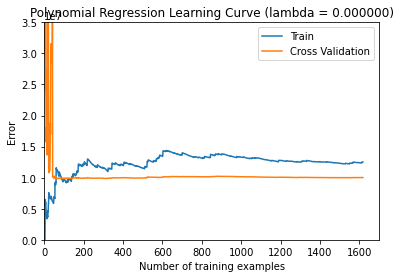

In [145]:
lambda_ = 0

pyplot.figure()
error_train_poly, error_val_poly = learningCurve(X_poly_norm_with_ones, y, X_poly_CV_norm_ones, y_CV, lambda_ )
pyplot.plot(np.arange(1, 1+m), error_train_poly, np.arange(1, 1+m), error_val_poly)

pyplot.title('Polynomial Regression Learning Curve (lambda = %f)' % lambda_)
pyplot.xlabel('Number of training examples')
pyplot.ylabel('Error')
pyplot.axis([0, 1700, 0, 35000000])
pyplot.legend(['Train', 'Cross Validation'])

print('Polynomial Regression (lambda = %f)\n' % lambda_)
print('# Training Examples\tTrain Error\tCross Validation Error')
for i in range(m):
    print('  \t%d\t\t%f\t%f' % (i+1, error_train_poly[i], error_val_poly[i]))

Determining the R² Value:

In [158]:
y_pred_poly = np.dot(X_poly_norm_with_ones, theta_poly)
#print(y_pred_poly)
#print(y)
print("R² for polynomial model:",r2_score(y, y_pred_poly))

R² for polynomial model: 0.4060121639484905


Price prediction:

In [146]:
X_prediction = [1, 75000, 75000**2, 75000**3] #for a car with 75 000 miles
X_prediction[1:4] = (X_prediction[1:4] - mu) / sigma
#print(np.array(X_prediction).shape)
price = np.dot(X_prediction, theta_poly)
print(price)

16539.757570632864


# Price prediction of specific brand: Mercedes

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

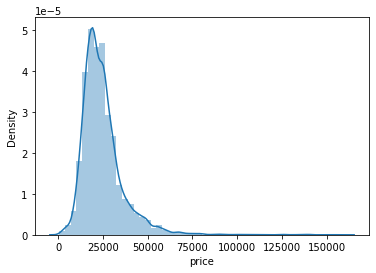

In [200]:
sbn.distplot(mercedes["price"])

Niet goed, we gaan proberen te filteren van 0-  60 000 :

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

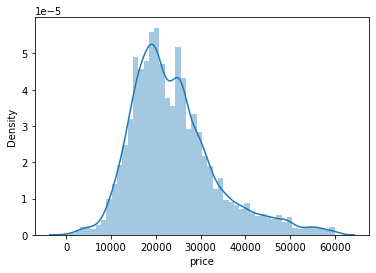

In [202]:
mercedes = mercedes.loc[(mercedes['price'] >= 0) & (mercedes['price'] <= 60000)]
sbn.distplot(mercedes["price"])

Data inladen en categorical variabelen fixen:

In [203]:
data_mercedes_expanded = pd.get_dummies(mercedes)
data_mercedes_expanded.drop('brand_mercedes', axis=1, inplace=True)
data_mercedes_expanded.head()

,year,price,mileage,tax,mpg,engineSize,model_ A Class,model_ B Class,model_ C Class,model_ CL Class,...,model_220,model_230,transmission_Automatic,transmission_Manual,transmission_Other,transmission_Semi-Auto,fuelType_Diesel,fuelType_Hybrid,fuelType_Other,fuelType_Petrol
0,2005,5200,63000,325,32.1,1.8,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,2017,34948,27000,20,61.4,2.1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,2016,49948,6200,555,28.0,5.5,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
6,2018,30948,16000,145,47.9,2.1,0,0,0,0,...,0,0,1,0,0,0,1,0,0,0
7,2012,10948,107000,265,36.7,3.5,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1


Data normaliseren:

In [204]:
mercedes_expanded_numpy = data_mercedes_expanded.to_numpy()
print("Numpy dataset: \n",mercedes_expanded_numpy)
print("\nShape dataset: ",mercedes_expanded_numpy.shape)

mu_mercedes = np.mean(mercedes_expanded_numpy, axis=0)
#print(mu_mercedes)
sigma_mercedes = np.std(mercedes_expanded_numpy, axis=0)
#print(sigma_mercedes)
mercedes_expanded_numpy_norm = (mercedes_expanded_numpy - mu_mercedes) / sigma_mercedes
print("\nNormalized Mercedes dataset: \n",mercedes_expanded_numpy_norm)

Numpy dataset: 
 [[2.0050e+03 5.2000e+03 6.3000e+04 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 [2.0170e+03 3.4948e+04 2.7000e+04 ... 1.0000e+00 0.0000e+00 0.0000e+00]
 [2.0160e+03 4.9948e+04 6.2000e+03 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 ...
 [2.0190e+03 3.0999e+04 1.1612e+04 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [2.0190e+03 3.7990e+04 2.4260e+03 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [2.0190e+03 5.4999e+04 2.0750e+03 ... 0.0000e+00 0.0000e+00 0.0000e+00]]

Shape dataset:  (12943, 41)

Normalized Mercedes dataset: 
 [[-5.5063881  -1.94899173  1.92461731 ... -0.1163932  -0.02326211
   1.61036689]
 [-0.12362107  1.14474363  0.22662574 ...  8.59156731 -0.02326211
  -0.6209765 ]
 [-0.57218499  2.70471507 -0.75443605 ... -0.1163932  -0.02326211
   1.61036689]
 ...
 [ 0.77350677  0.73405515 -0.49917132 ... -0.1163932  -0.02326211
  -0.6209765 ]
 [ 0.77350677  1.46110583 -0.93244217 ... -0.1163932  -0.02326211
  -0.6209765 ]
 [ 0.77350677  3.23000945 -0.94899759 ... -0.1163932  -0.02326211
  

Selecting how much features and which features to be selected:

In [205]:
column_names_mercedes = data_mercedes_expanded.drop(columns = ['price']).columns
print(column_names_mercedes)

Index(['year', 'mileage', 'tax', 'mpg', 'engineSize', 'model_ A Class',
       'model_ B Class', 'model_ C Class', 'model_ CL Class',
       'model_ CLA Class', 'model_ CLC Class', 'model_ CLK',
       'model_ CLS Class', 'model_ E Class', 'model_ G Class',
       'model_ GL Class', 'model_ GLA Class', 'model_ GLB Class',
       'model_ GLC Class', 'model_ GLE Class', 'model_ GLS Class',
       'model_ M Class', 'model_ R Class', 'model_ S Class', 'model_ SL CLASS',
       'model_ SLK', 'model_ V Class', 'model_ X-CLASS', 'model_180',
       'model_200', 'model_220', 'model_230', 'transmission_Automatic',
       'transmission_Manual', 'transmission_Other', 'transmission_Semi-Auto',
       'fuelType_Diesel', 'fuelType_Hybrid', 'fuelType_Other',
       'fuelType_Petrol'],
      dtype='object')


(12943, 40)
(12943,)
(12943, 41)


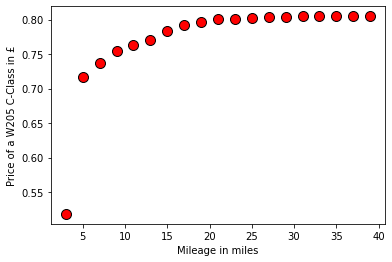

In [226]:
#data
X_mercedes = np.delete(mercedes_expanded_numpy_norm, 1, axis=1)
y_mercedes = mercedes_expanded_numpy_norm[:,1]
print(X_mercedes.shape)
print(y_mercedes.shape)
print(mercedes_expanded_numpy_norm.shape)


#for features
no_of_features = []
r_squared = []


for k in range(3, 40, 2):
    selector = SelectKBest(f_regression, k = k)
    X_transformed = selector.fit_transform(X_mercedes, y_mercedes)
    regressor = LinearRegression()
    regressor.fit(X_transformed, y_mercedes)
    no_of_features.append(k)
    teller = (1-(regressor.score(X_transformed, y_mercedes)))*(y_mercedes.size-1)
    noemer = y_mercedes.size-1
    r_squared.append(1-(teller/noemer))

plotData(no_of_features, r_squared)


In [259]:
selector = SelectKBest(f_regression, k = 3)
X_train_transformed = selector.fit_transform(X_mercedes, y_mercedes)
features_columns = column_names_mercedes[selector.get_support()]
print(features_columns.to_numpy().tolist())

['year', 'mileage', 'mpg']


In [260]:
data_mercedes_expanded_filtered = data_mercedes_expanded[features_columns.to_numpy().tolist()]
data_mercedes_expanded_filtered.head()

,year,mileage,mpg
0,2005,63000,32.1
1,2017,27000,61.4
2,2016,6200,28.0
6,2018,16000,47.9
7,2012,107000,36.7


Normalise features and convert to numpy:

In [269]:
mercedes_expanded_goodfeatures_numpy = data_mercedes_expanded_filtered.to_numpy()
print(mercedes_expanded_goodfeatures_numpy)

#normalize
mu_mercedes_features = np.mean(mercedes_expanded_goodfeatures_numpy, axis=0)
#print(mu_mercedes)
sigma_mercedes_features = np.std(mercedes_expanded_goodfeatures_numpy, axis=0)
#print(sigma_mercedes)
mercedes_expanded_features_norm = (mercedes_expanded_goodfeatures_numpy - mu_mercedes_features) / sigma_mercedes_features
print("\nNormalized Mercedes dataset: \n",mercedes_expanded_features_norm)

[[2.0050e+03 6.3000e+04 3.2100e+01]
 [2.0170e+03 2.7000e+04 6.1400e+01]
 [2.0160e+03 6.2000e+03 2.8000e+01]
 ...
 [2.0190e+03 1.1612e+04 4.1500e+01]
 [2.0190e+03 2.4260e+03 4.5600e+01]
 [2.0190e+03 2.0750e+03 5.2300e+01]]
[2.01727559e+03 2.39406482e+04 2.21951901e+04 1.29621803e+02
 5.55131886e+01 2.04547632e+00 1.95549718e-01 4.56617477e-02
 2.87259523e-01 3.94808004e-02 6.64451827e-03 2.31785521e-04
 5.40832883e-04 1.81565325e-02 1.50274280e-01 2.31785521e-04
 9.34868269e-03 6.54407788e-02 1.46797497e-03 7.22398208e-02
 3.47678282e-02 4.79023410e-03 6.10368539e-03 1.54523681e-04
 1.25936800e-02 1.90836746e-02 7.33987484e-03 1.59932010e-02
 6.33547091e-03 7.72618404e-05 7.72618404e-05 7.72618404e-05
 7.72618404e-05 3.67380051e-01 1.11566098e-01 1.54523681e-04
 5.20899328e-01 7.07795720e-01 1.33662984e-02 5.40832883e-04
 2.78297149e-01]
[2.22933668e+00 9.61556065e+03 2.12015187e+04 6.52648541e+01
 1.49870052e+01 5.24038001e-01 3.96623279e-01 2.08750455e-01
 4.52483689e-01 1.94735890e-0

Paste 1's before continueing:

In [262]:
m_merc = y_mercedes.size #dataset size
X_multi_merc = np.concatenate([np.ones((m_merc, 1)), mercedes_expanded_features_norm], axis=1)
print(X_multi_merc)
#print(mercedes_expanded_features_norm.shape)
#print(m_merc)


[[ 1.         -5.5063881   1.92461731 -1.56223264]
 [ 1.         -0.12362107  0.22662574  0.39279438]
 [ 1.         -0.57218499 -0.75443605 -1.83580297]
 ...
 [ 1.          0.77350677 -0.49917132 -0.9350226 ]
 [ 1.          0.77350677 -0.93244217 -0.66145227]
 [ 1.          0.77350677 -0.94899759 -0.21439831]]


Some functions to compute cost and gradient descent for multiple features:

In [263]:
def computeCostMulti(X, y, theta, lambda_ = 0):
    """
    Compute cost for linear regression with multiple variables.
    Computes the cost of using theta as the parameter for linear regression to fit the data points in X and y.
    
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        A vector of shape (m, ) for the values at a given data point.
    
    theta : array_like
        The linear regression parameters. A vector of shape (n+1, )
    
    Returns
    -------
    J : float
        The value of the cost function. 
    
    Instructions
    ------------
    Compute the cost of a particular choice of theta. You should set J to the cost.
    """
    # Initialize some useful values
    m = y.shape[0] # number of training examples
    
    # You need to return the following variable correctly
    J = 0
    grad = np.zeros(theta.shape)
    
    # ======================= YOUR CODE HERE ===========================
    h = np.dot(X, theta)
    
    J = (1/(2 * m)) * np.sum(np.square(np.dot(X, theta) - y)) + (lambda_/(2*m))*(np.sum(theta[1:]**2))
    grad = (1 / m) * (h - y).dot(X)
    grad[1:] = grad[1:] + (lambda_ / m) * theta[1:]
    # ==================================================================
    return J, grad

def gradientDescentMulti(X, y, theta, alpha, num_iters):
    """
    Performs gradient descent to learn theta.
    Updates theta by taking num_iters gradient steps with learning rate alpha.
        
    Parameters
    ----------
    X : array_like
        The dataset of shape (m x n+1).
    
    y : array_like
        A vector of shape (m, ) for the values at a given data point.
    
    theta : array_like
        The linear regression parameters. A vector of shape (n+1, )
    
    alpha : float
        The learning rate for gradient descent. 
    
    num_iters : int
        The number of iterations to run gradient descent. 
    
    Returns
    -------
    theta : array_like
        The learned linear regression parameters. A vector of shape (n+1, ).
    
    J_history : list
        A python list for the values of the cost function after each iteration.
    
    Instructions
    ------------
    Peform a single gradient step on the parameter vector theta.

    While debugging, it can be useful to print out the values of 
    the cost function (computeCost) and gradient here.
    """
    # Initialize some useful values
    m = y.shape[0] # number of training examples
    
    # make a copy of theta, which will be updated by gradient descent
    theta = theta.copy()
    
    J_history = []
    
    for i in range(num_iters):
        # ======================= YOUR CODE HERE ==========================

        theta = theta - (alpha / m) * (np.dot(X, theta) - y).dot(X)
        # =================================================================
        
        # save the cost J in every iteration
        J_history.append(computeCostMulti(X, y, theta))
    
    return theta, J_history


In [264]:
"""
# initialize fitting parameters
theta_multivariate_merc = np.zeros(26)

# some gradient descent settings
iterations = 100000
alpha = 0.1

theta_multivariate_merc, J_history_multi = gradientDescentMulti(X_multi_merc ,y_mercedes, theta_multivariate_merc, alpha, iterations)
print('Theta found by gradient descent: {:.4f}, {:.4f}'.format(*theta_multivariate_merc))
"""


lambda_ = 0
theta_multi = trainLinearReg(computeCostMulti, X_multi_merc, y_mercedes,
                             lambda_=lambda_, maxiter=1000)
print(theta_multi)


"""
# Choose some alpha value - change this
alpha = 0.00001
num_iters = 200000

# init theta and run gradient descent
theta_multi = np.zeros(21)
theta_multi, J_history = gradientDescentMulti(X_multi_merc, y_mercedes, theta_multi, alpha, num_iters)
print(theta_multi)
"""

[ 1.36141252e-08  3.77668431e-01 -2.61549780e-01 -3.30346894e-01]


'\n# Choose some alpha value - change this\nalpha = 0.00001\nnum_iters = 200000\n\n# init theta and run gradient descent\ntheta_multi = np.zeros(21)\ntheta_multi, J_history = gradientDescentMulti(X_multi_merc, y_mercedes, theta_multi, alpha, num_iters)\nprint(theta_multi)\n'

In [270]:
#['year', 'mileage', 'tax', 'mpg', 'engineSize', 'model_ A Class', 
#'model_ B Class', 'model_ E Class', 'model_ GLA Class', 'model_ GLC Class', 
#'model_ GLE Class', 'model_ GLS Class', 'model_ S Class', 
#'model_ SL CLASS', 'model_ SLK', 'model_ V Class', 
#'transmission_Manual', 'transmission_Semi-Auto', 'fuelType_Diesel', 
#'fuelType_Petrol']
X_prediction = [1, 2019, 20498, 30] 
X_prediction[1:4] = (X_prediction[1:4] - mu_mercedes_features) / sigma_mercedes_features
#print(np.array(X_prediction).shape)
price = np.dot(X_prediction, theta_multi)
print(price)

pyplot.plot(np.arange(len(J_history)), J_history, lw=2)
pyplot.xlabel('Number of iterations')
pyplot.ylabel('Cost J')

ValueError: operands could not be broadcast together with shapes (3,) (41,) 

In [236]:
def regression_model(model):
    regressor = model
    regressor.fit(X_multi_merc, y_mercedes)
    score = regressor.score(X_multi_merc, y_mercedes)
    return regressor, score

In [237]:
regressor, score = regression_model(LinearRegression())
print(score)

0.8001519914546769


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

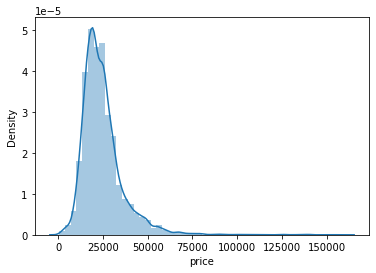

In [195]:
sbn.distplot(mercedes["price"])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='price', ylabel='Density'>

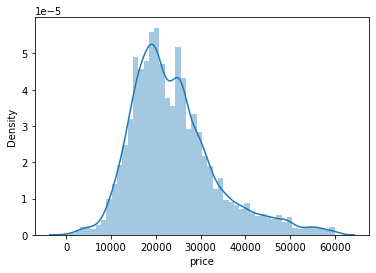